In [45]:
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from Memory import ReplayMemory
from SACV2 import SoftActorCritic
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
import sys
sys.path.append("..")
from behavioral_sim.custom_envs import BehavSimEnv
from behavioral_sim.custom_envs import HourlySimEnv

from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
"""
My rough code to train and experiment with SACV2, I pretty much just call the train function below


"""

replay_size = 10000


total_numsteps = 60
start_steps = 30
batch_size = 1
action_star = None

## Helper functions

In [3]:

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def series_to_supervised(data,
                         n_in,
                         target_features,
                         col_names=None,
                         n_out=1,
                         dropnan=True,
                         initial_excluded_timesteps=0,
                         removed_features=[],
                         only_current_timestep_features=[]):
    """Takes time series data and converts it into a supervised learning
    problem framework.

        Parameters:
            - data (pd.Dataframe) -- the time series data to be converted.
            - n_in (int) -- Number of time steps to use as lag for the feature 
                matrix
            - col_names (List[str]) -- list of strings to use as column names,
                that get converted into features for each time lag
            - target_features (List[str]) -- List of features that will be used
                as dependent variables in the target matrix.
            - n_out (int) -- Number of time steps to use as lag for the target
                matrix
            - dropnan (bool) -- Whether to drop nan values
            - initial_excluded_timesteps (int) -- The number of input timesteps to 
                ignore before starting the time lag.
            - removed_features (List[str]) -- List of features that should be removed
                from the dataframe. 
            - only_current_timestep_features (List[str]) -- Features that should
            only be included in the current timestep, not any before (e.g.) to avoid
            unintended dependencies
            
            - [Planned] exclude_current_day (bool) -- Whether to include values 
                from the current day. If this parameter is false, then the time lag 
                will always start with the day preceding the current time 
                step.
                
        Outputs:
            - (X, y): (Feature matrix, target matrix)
    """
    
    if col_names is None:
        col_names = data.columns
        
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data).drop(removed_features, axis=1)
    col_names = [x for x in col_names if x not in removed_features]
    cols, names = list(), list()      
        
    only_prev_time_features = df.drop(only_current_timestep_features, axis=1)
    only_prev_column_names = [x for x in col_names if x in only_prev_time_features.columns]

    # (t-n, ... t-1) --> i.e. steps into the past
    for i in range(n_in + initial_excluded_timesteps, initial_excluded_timesteps, -1):
        cols.append(only_prev_time_features.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in only_prev_column_names]

    # (t, t+1, ... t+n) --> i.e. steps into the future
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col)) for col in col_names]
        else:
            names += [('%s(t + %d)' % (col, i)) for col in col_names]

    # concat
    agg = pd.concat(cols, axis=1)
#     agg.columns = names

    # dropnan
    if dropnan:
        agg.dropna(inplace=True)
    
    if target_features: 
        Y_vals_cols = ([('%s(t)' % (col)) for col in target_features] + 
            ['%s(t + %d)' % (col, i) for col in target_features for i in range(1, n_out)])

        Y_vals = agg[Y_vals_cols]
        X_vals = agg.drop(Y_vals_cols, axis=1)

        agg.columns = names
              
        return X_vals, Y_vals # X_vals.values, Y_vals.values
    
    else:
        return agg, _



In [4]:
def planning_prediction(action, day_of_week, planning_model_type = "OLS", loaded_model = None):

    ## Basic LSTM that follows the rules of the experiment    
    if planning_model_type == "LSTM":
        ## load the minMaxScalers
        with open ("scaler_X.pickle", "rb") as input_file:
            scaler_X = pickle.load(input_file) 
        with open ("scaler_y.pickle", "rb") as input_file:
            scaler_y = pickle.load(input_file) 

        ## prepare the data

        d_X = pd.DataFrame(data = { "action"  : action, "dow" : day_of_week } )
        scaled_X = scaler_X.transform(d_X)
        sxr = scaled_X.reshape((scaled_X.shape[0], 1, scaled_X.shape[1])) 

        preds = loaded_model.predict(sxr)

        inv_preds = scaler_y.inverse_transform(preds)  

        return np.squeeze(inv_preds)
    
    
    # simple OLS trained on small dataset without IV 
    elif planning_model_type == "OLS":
        energy = 246 + -3.26 * np.array(action)
        return energy
    
    # baseline model that just returns average of the sample energy day
    elif planning_model_type == "baseline":
        return 70.7
    
    else:
        raise ValueError("wrong planning model choice")
        return

## Train the planning model with more data 

In [5]:
def train_planning_model(
    energy_today, 
    action, 
    day_of_week, 
    loaded_model, 
    filename_to_save = "GPyOpt_planning_model"
):
    
    ## load the minMaxScalers
    with open ("scaler_X.pickle", "rb") as input_file:
        scaler_X = pickle.load(input_file) 
    with open ("scaler_y.pickle", "rb") as input_file:
        scaler_y = pickle.load(input_file) 

    ## prepare the data

    d_X = pd.DataFrame(data = { "action" : action, "dow" : day_of_week } )
    scaled_X = scaler_X.transform(d_X)
    sxr = scaled_X.reshape((scaled_X.shape[0], 1, scaled_X.shape[1])) 
    
    d_y = pd.DataFrame(data = {"energy" : energy_today})
    scaled_y = scaler_y.transform(d_y)
    
    loaded_model.fit(
            sxr,    ## these all need to be changed if the GPyOpt evaluates differently
            scaled_y,
            epochs=100,
            batch_size=10,
            validation_split=0.0,
            verbose=0,
        )
    
    model_json = loaded_model.to_json()
    with open(filename_to_save + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    loaded_model.save_weights(filename_to_save + ".h5")
    print("Saved model to disk")
    
    return

## load model

In [6]:
def load_model_from_disk(file_name = "GPyOpt_planning_model"):
    json_file = open(file_name + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(file_name + ".h5")
    print("Loaded model from disk")

    loaded_model.compile(loss="mse", optimizer="adam")
    return loaded_model

## Train function


In [16]:
def train(
    response_type_str, 
    extra_train, 
    planning_iterations,
    total_days = 60,
    one_day = False, 
    energy=True, 
    day_of_week=True, 
    planning_model = False,
    train_planning_model_with_new_data = False,
    batch_size_agent = 1,
    short_term_planning = False,
    planning_model_type = "LSTM",
    ):
    """
    Parameters: 
        - Response_type_str = 'theshold_exp' or 'sin' or 'mixed' or 'linear'
        - Extra_Train = Number of iterations to "overtrain"
        - planning_iterations = number of times to query the planning model
        - total_days: (int) total number of days to run the experiment for
        - One_day: Whether to train from a single day's price signal 
        - Energy: Whether or not to include previous day energy in the state
        - Day_of_Week: Whether or not to include day_of_week multiplier
        - planning_model: whether or not to use the planning model
        - train_planning_model_with_new_data: whether to train the planning model
        - batch_size_agent: number of samples to draw from buffer
        - short_term_planning: whether to erase the short term memory buffer each time
        - planning_model_type: whether to use an LSTM or regression
    
    Summary:
        This code 'simulates' a run of SACV2 training and acting over 30 days (takes a step each day)

    """
    if(response_type_str == 'threshold_exp'):
        #env = HourlySimEnv(response='t', one_day=True, energy_in_state=False)
        env2 = BehavSimEnv(response='t', one_day = one_day, energy_in_state=energy, yesterday_in_state=False,
                            day_of_week = day_of_week)
    elif(response_type_str == 'sin'):
        #env = HourlySimEnv(response='s',one_day=True, energy_in_state=False)
        env2 = BehavSimEnv(response='s', one_day=one_day, energy_in_state=energy, yesterday_in_state=False,
                            day_of_week = day_of_week)
    elif(response_type_str == 'mixed'):
        #env = HourlySimEnv(response='s',one_day=True, energy_in_state=False)
        env2 = BehavSimEnv(response='m', one_day=one_day, energy_in_state=energy, yesterday_in_state=False,
                            day_of_week = day_of_week)
    elif(response_type_str == 'linear'):
        #env = HourlySimEnv(response='l',one_day=True, energy_in_state=False)
        env2 = BehavSimEnv(response='l', one_day=one_day, energy_in_state=energy,yesterday_in_state=False,
                            day_of_week = day_of_week)
    
    else:
        raise NotImplementedError

    #rewards in environment that agents see
    rewards = []

    #optional rewards list for environment that agent doesn't see (used in one-day training -> generalization case)
    rewards2 = []

    min_combined_losses = []
    min_policy_losses = []
    min_alpha_losses = []
    num_iters_list = []
    overall_best_action = None

    memory = ReplayMemory(replay_size)

    #Sometimes use 2 environment, this is used to default to 1 env. 
    #Change if you want to use 2 environments
    env = env2

    action_star = []
    state = None


    agent = SoftActorCritic(env.observation_space, env.action_space, memory)

    reward_planning = []
    
    # Actions 2 save and energy_usage for data_generation
    # actions_2_save = []
    # energy_usage = []

    # Flag corresp to whether first state has been initialized
    start_flag = False

    day = 0 
        
    while (day <= total_days):
        step = env.day
        day_of_week = env.day % 7 
        print("Day: " + str(day))
        if (not start_flag):
            action = env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            state = np.copy(next_state)
            start_flag = True
            continue

        if env.day <= 30:
            action = env.action_space.sample()  # Sample random action
            next_state, reward, done, info = env.step(action)

            memory.push((state, action, reward, next_state, done))

            state = np.copy(next_state)
            day += 1 
            
            continue
            
        else:
            if(memory.get_len() > batch_size_agent):
                actions = []
                for extra_step in range(extra_train):
                    print("--"*10)
                    print(" Extra Train " + str(extra_step))
                    
                    return_update = agent.update_params(batch_size_agent, memory_type = "replay")

                energy_yesterday = np.copy(next_state[:10])

                if planning_model:
                    
                    ## load model from disk now   
                    if train_planning_model_with_new_data:
                        if (env.day==31):
                            loaded_model = load_model_from_disk("GPyOpt_planning_model")
                        else:
                            loaded_model = load_model_from_disk("GPyOpt_planning_model_training")
                    else: 
                        if planning_model_type == "LSTM":
                            loaded_model = load_model_from_disk("GPyOpt_planning_model")
                        else:
                            loaded_model = None
            
                    agent.reset_short_term_memory()
                
                    for planning_step in range(planning_iterations):
                        print("--"*10)
                        print(" planning step " + str(planning_step))

                        grid_prices_today = env.prices[env.day] # assuming that the env.day here correctly is set to the correct day
                        grid_prices_tmr = env.prices[(env.day + 1) % 365]
                        # state is defined as [previous day energy, current day prices] 
                        # I don't currently want this to change, as it should be the same to allow agent to explore

                        state = np.concatenate((energy_yesterday, grid_prices_today))
                        action = agent.get_action(state)
                        
                        print("action: " + str(action))
                    
                        planned_energy_consumption = planning_prediction(
                            action, 
                            day_of_week, 
                            planning_model_type = planning_model_type,
                            loaded_model = loaded_model)
                        
                        # will define next state as [energy, grid prices tomorrow]

                        next_state = np.concatenate((planned_energy_consumption, grid_prices_tmr))
                        reward = env.get_reward_planning_model(grid_prices_today, planned_energy_consumption) 
                        done = True
                        
                        agent.planning_replay_memory.push((state, action, reward, next_state, done))
                        agent.short_term_planning_replay_memory.push((state, action, reward, next_state, done))
                        
                        # if there's enough in the planning replay buffer, then train with it 
                        if (agent.planning_replay_memory.get_len() > batch_size_agent):
                            if not short_term_planning:
                                return_update = agent.update_params(batch_size_agent, memory_type = "planning")
                        
                        # if we're doing short term memory planning, then train in the same manner
                        if (agent.short_term_planning_replay_memory.get_len() > batch_size_agent):
                            if short_term_planning:
                                return_update = agent.update_params(batch_size_agent, memory_type = "short term planning")
                        
                        reward_planning.append(reward)
            
            action = agent.get_action(state)
            
            next_state, reward, done, info = env.step(action)

            memory.push((state, action, reward, next_state, done))
            
            # train the planning model 
            energy_today = np.copy(next_state[:10])
                        
            # if training the planning model is the flag that we'll change, then 
            # change over to "planning_model_training" and train it 
            
            if train_planning_model_with_new_data:
                if env.day == 31:
                    loaded_model = load_model_from_disk("GPyOpt_planning_model_training")
                    
                train_planning_model(    
                    energy_today = energy_today, 
                    action = action, 
                    day_of_week = day_of_week, 
                    loaded_model = loaded_model
                )
            
            state = np.copy(next_state)

            if(done):
                rewards.append(reward)
            print("--------" * 10)
            
            day += 1
    
    return rewards, reward_planning



## Long term tests 

In [ ]:
rewards_lt, _ = train(
         response_type_str = "linear", 
         extra_train = 0, 
         total_days = 1000,
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 10
         )

In [18]:
rewards_planning_lt, planning_rewards_lt = train(
         response_type_strewards_vanillaxed", 
         extra_train = 0, 
         total_days = 1000,
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 10
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Loaded model from disk
--------------------
 planning step 0
action: [ 0. 10.  0.  0.  0.  0.  0. 10. 10. 10.]
--------------------
 planning step 1
action: [ 0. 10.  0.  0.  0.  0.  0. 10. 10. 10.]
--------------------
 planning step 2
action: [ 0. 10.  0.  0.  0.  0.  0. 

## Plotting the results

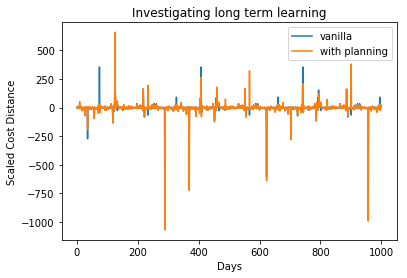

In [28]:
plt.figure()
plt.plot(rewards_vanilla, label = "vanilla")
plt.plot(rewards_planning_lt, label = "with planning")
plt.xlabel("Days")
plt.ylabel("Scaled Cost Distance")
plt.legend()
plt.title("Investigating long term learning")
plt.show()

## Checking out the sample energy bug

In [39]:
from behavioral_sim.agents import *

In [41]:
player_dict = {}
sample_energy = np.array([ 0.28,  11.9,   16.34,  16.8,  17.43,  16.15,  16.23,  15.88,  15.09,  35.6,
                                123.5,  148.7,  158.49, 149.13, 159.32, 157.62, 158.8,  156.49, 147.04,  70.76,
                                42.87,  23.13,  22.52,  16.8])

#only grab working hours (8am - 6pm)
working_hour_energy = sample_energy[8:18]

my_baseline_energy = pd.DataFrame(data={"net_energy_use": working_hour_energy})
player_dict['player_0'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 10, response= 't')
player_dict['player_1'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 10, response='t')
player_dict['player_2'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 10, response ='s')
player_dict['player_3'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 10,response ='s')
player_dict['player_4'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 10,response ='s')
player_dict['player_5'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 10,response ='l')
player_dict['player_6'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 10, response ='l')
player_dict['player_7'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 10, response ='l')


In [43]:
for player_name in energy_consumptions:
    if player_name != "avg":
        # get the points output from players
        player = self.player_dict[player_name]

        # get the reward from the player's output
        player_min_demand = player.get_min_demand()
        player_max_demand = player.get_max_demand()
        player_energy = energy_consumptions[player_name]
        player_reward = Reward(player_energy, prev_observation, player_min_demand, player_max_demand)
        player_ideal_demands = player_reward.ideal_use_calculation()
        #self.prev_ideal = player_ideal_demands
        # either distance from ideal or cost distance
        # distance = player_reward.neg_distance_from_ideal(player_ideal_demands)

        IPython.embed()
        reward = player_reward.scaled_cost_distance(player_ideal_demands)

        total_reward += reward


NameError: name 'energy_consumptions' is not defined